# ETL_EDA
This file records the process of acquiring raw data, traforming them, and loading them into a MongoDB. The data are store (almost) in their raw form.

## 1. Raw Data from BPA 
The [dataset](https://transmission.bpa.gov/business/operations/Wind/baltwg.txt) is a continuously updated txt file in csv format. It contains the energy producation and load in the last 5 days. There will be some blank lines at the end for today. It can be retrieved simply by making `requests` without parameters. For more complicated API call, you may need to add query parameters.

In [44]:
import requests

url = "https://data.cdc.gov/api/views/9mfq-cb36/rows.csv?accessType=DOWNLOAD"
req = requests.get(url, timeout=0.5)
req.raise_for_status()
text = req.text
print(text[:1000])
print('...')
print(text[-500:])

submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
04/01/2021,CA,3570660,3570660,0,2234,0,58090,58090,0,154,0,04/03/2021 12:00:00 AM,Agree,Agree
05/31/2021,CA,3685032,3685032,0,644,0,62011,62011,0,5,0,06/02/2021 12:00:00 AM,Agree,Agree
02/06/2020,NE,0,,,0,,0,,,0,,03/26/2020 04:22:39 PM,Agree,Agree
07/30/2020,ME,3910,3497,413,22,2,123,122,1,2,0,07/31/2020 02:35:06 PM,Agree,Agree
02/02/2021,MS,280182,176228,103954,1059,559,6730,4739,1991,13,7,02/04/2021 12:00:00 AM,Agree,Agree
05/03/2020,NH,2518,,,89,0,86,,,2,0,05/04/2020 10:49:24 PM,Not agree,Not agree
07/31/2020,ND,6602,6602,0,133,0,103,,,0,0,08/01/2020 02:38:12 PM,Agree,Not agree
08/11/2020,GU,449,,,15,0,5,,,0,0,08/12/2020 01:50:14 PM,Not agree,Not agree
07/07/2020,NE,20150,,,179,0,282,,,-1,0,07/09/2020 12:00:00 AM,Not agree,Not agree
01/27/2020,MI,0,,,0,,0,,,0,,03/26/2020 04:22:39 PM,Agree,Agree
02/14/2021,CT,267337,2509

## 2. Raw Data to Documents/Dicts
Using pandas, it is simple to parse a in-memory string. The first few lines of description need to be skipped. Datetime conversion is made and blank lines are dropped. Now the data can be easily converted to a list of dicts which is what we want for the MongoDB.

In [47]:
import pandas as pd
from io import StringIO

df = pd.read_csv(StringIO(text), usecols=["pnew_case", "new_case", "tot_cases", "state", "created_at"], delimiter = ',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['Datetime'] = pd.to_datetime(df['created_at'])
#df.submission_date = pd.to_datetime(df['submission_date'])
df.drop(columns=['created_at'], axis=1, inplace=True)
df.dropna(inplace=True)  
df.head()

,state,tot_cases,new_case,pnew_case,Datetime
0,CA,3570660,2234,0.0,2021-04-03 00:00:00
1,CA,3685032,644,0.0,2021-06-02 00:00:00
3,ME,3910,22,2.0,2020-07-31 14:35:06
4,MS,280182,1059,559.0,2021-02-04 00:00:00
5,NH,2518,89,0.0,2020-05-04 22:49:24


In [48]:
df.state.unique()

array(['CA', 'ME', 'MS', 'NH', 'ND', 'GU', 'NE', 'CT', 'WI', 'NC', 'AL',
       'MO', 'IL', 'NV', 'MI', 'IN', 'WA', 'VT', 'MD', 'DE', 'MT', 'VI',
       'ID', 'LA', 'DC', 'NJ', 'RI', 'MN', 'AZ', 'FSM', 'SC', 'KY', 'OR',
       'VA', 'WY', 'UT', 'CO', 'AR', 'PW', 'MP', 'MA', 'PR', 'GA', 'NYC',
       'AS', 'OK', 'AK', 'KS', 'TX', 'FL', 'WV', 'HI', 'TN', 'PA', 'IA',
       'OH', 'RMI', 'SD', 'NY', 'NM'], dtype=object)

In [49]:
ca_df = df[df.state == "CA"]
me_df = df[df.state == "ME"]
ms_df = df[df.state == "MS"]
nh_df = df[df.state == "NH"]
nd_df = df[df.state == "ND"]
gu_df = df[df.state == "GU"]
ne_df = df[df.state == "NE"]
ct_df = df[df.state == "CT"]
wi_df = df[df.state == "WI"]
nc_df = df[df.state == "NC"]
al_df = df[df.state == "AL"]
mo_df = df[df.state == "MO"]
il_df = df[df.state == "IL"]
nv_df = df[df.state == "NV"]
mi_df = df[df.state == "MI"]
in_df = df[df.state == "IN"]
wa_df = df[df.state == "WA"]
vt_df = df[df.state == "VT"]
md_df = df[df.state == "MD"]
de_df = df[df.state == "DE"]
mt_df = df[df.state == "MT"]
vi_df = df[df.state == "VI"]
id_df = df[df.state == "ID"]
la_df = df[df.state == "LA"]
dc_df = df[df.state == "DC"]
nj_df = df[df.state == "NJ"]
ri_df = df[df.state == "RI"]
mn_df = df[df.state == "MN"]
az_df = df[df.state == "AZ"]
fsm_df = df[df.state == "FSM"]
sc_df = df[df.state == "SC"]
ky_df = df[df.state == "KY"]
or_df = df[df.state == "OR"]
va_df = df[df.state == "VA"]
wy_df = df[df.state == "WY"]
ut_df = df[df.state == "UT"]
co_df = df[df.state == "CO"]
ar_df = df[df.state == "AR"]
pw_df = df[df.state == "PW"]
mp_df = df[df.state == "MP"]
ma_df = df[df.state == "MA"]
pr_df = df[df.state == "PR"]
ga_df = df[df.state == "GA"]
nyc_df = df[df.state == "NYC"]
as_df = df[df.state == "AS"]
ok_df = df[df.state == "OK"]
ak_df = df[df.state == "AK"]
ks_df = df[df.state == "KS"]
tx_df = df[df.state == "TX"]
fl_df = df[df.state == "FL"]
wv_df = df[df.state == "WV"]
hi_df = df[df.state == "HI"]
tn_df = df[df.state == "TN"]
pa_df = df[df.state == "PA"]
ia_df = df[df.state == "IA"]
oh_df = df[df.state == "OH"]
rmi_df = df[df.state == "RMI"]
sd_df = df[df.state == "SD"]
ny_df = df[df.state == "NY"]
nm_df = df[df.state == "NM"]

In [50]:
# prints the number of rows
print('number of rows: ' , df.shape[0])
# prints the number of columns
print('number of columns: ' , df.shape[1])

# prints data types of all columns
print(df.dtypes)

number of rows:  37219
number of columns:  5
state                object
tot_cases             int64
new_case              int64
pnew_case           float64
Datetime     datetime64[ns]
dtype: object


In [51]:
cat_ftrs = ['state', 'consent_cases', 'consent_deaths']

ss_ftrs = ['tot_cases', 'conf_cases', 'prob_cases', 'new_case', 'pnew_case', 'tot_death', 'conf_death', 'prob_death', 'new_death', 'pnew_death']

dates = ['submission_date', 'created_at']

In [52]:
df.describe()

,tot_cases,new_case,pnew_case
count,3.721900e+04,37219.000000,37219.000000
mean,3.697116e+05,1309.671807,182.769795
std,6.218595e+05,2647.082199,520.764543
min,0.000000e+00,-10199.000000,-10733.000000
25%,1.731450e+04,79.500000,0.000000
50%,1.335400e+05,450.000000,4.000000
75%,4.762440e+05,1426.000000,146.000000
max,5.118139e+06,61016.000000,16591.000000


count    3.721900e+04
mean     3.697116e+05
std      6.218595e+05
min      0.000000e+00
25%      1.731450e+04
50%      1.335400e+05
75%      4.762440e+05
max      5.118139e+06
Name: tot_cases, dtype: float64


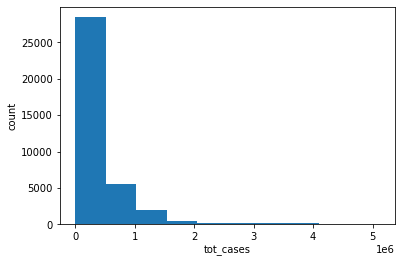

count    37219.000000
mean      1309.671807
std       2647.082199
min     -10199.000000
25%         79.500000
50%        450.000000
75%       1426.000000
max      61016.000000
Name: new_case, dtype: float64


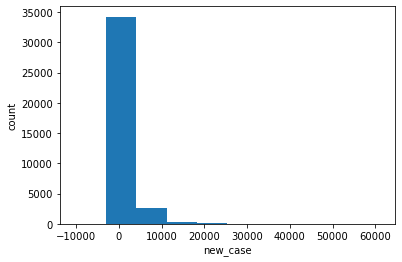

count    37219.000000
mean       182.769795
std        520.764543
min     -10733.000000
25%          0.000000
50%          4.000000
75%        146.000000
max      16591.000000
Name: pnew_case, dtype: float64


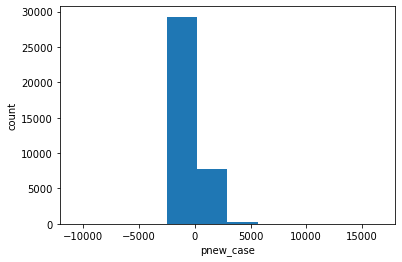

In [53]:
import matplotlib
from matplotlib import pylab as plt

#histograms/bar charts of all features
columns = df.columns
for col in columns:
    if col in ss_ftrs:
        print(df[col].describe())
        df[col].plot.hist()
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()

## 3. Upsert MongoDB
If we fetch the data frequently, there are lots of duplicate data entry between each run. The de-duplication happens at insertion. The MongoDB API to use is `collection.replace_one(filter=..., replacement=..., upsert=True)`. The statement matches a document in MongoDB with `filter`, replaces it with `replacement` if the document exists or inserts `replacement` into the database if `filter` matches nothing. 

In [12]:
import pymongo

client = pymongo.MongoClient()

In [54]:
db = client.get_database("corona")
collections = ["ca",
"me",
"ms",
"nh",
"nd",
"gu",
"ne",
"ct",
"wi",
"nc",
"al",
"mo",
"il",
"nv",
"mi",
"in",
"wa",
"vt",
"md",
"de",
"mt",
"vi",
"id",
"la",
"dc",
"nj",
"ri",
"mn",
"az",
"fsm",
"sc",
"ky",
"or",
"va",
"wy",
"ut",
"co",
"ar",
"pw",
"mp",
"ma",
"pr",
"ga",
"nyc",
"as",
"ok",
"ak",
"ks",
"tx",
"fl",
"wv",
"hi",
"tn",
"pa",
"ia",
"oh",
"rmi",
"sd",
"ny",
"nm"]

state_df = [ca_df,
me_df,
ms_df,
nh_df,
nd_df,
gu_df,
ne_df,
ct_df,
wi_df,
nc_df,
al_df,
mo_df,
il_df,
nv_df,
mi_df,
in_df,
wa_df,
vt_df,
md_df,
de_df,
mt_df,
vi_df,
id_df,
la_df,
dc_df,
nj_df,
ri_df,
mn_df,
az_df,
fsm_df,
sc_df,
ky_df,
or_df,
va_df,
wy_df,
ut_df,
co_df,
ar_df,
pw_df,
mp_df,
ma_df,
pr_df,
ga_df,
nyc_df,
as_df,
ok_df,
ak_df,
ks_df,
tx_df,
fl_df,
wv_df,
hi_df,
tn_df,
pa_df,
ia_df,
oh_df,
rmi_df,
sd_df,
ny_df,
nm_df]

for x in collections:
    collection = db.get_collection(x)
    update_count = 0
    for y in state_df:
        for record in y.to_dict('records'):
            result = collection.replace_one(
                filter={'Datetime': record['Datetime']},    # locate the document if exists
                replacement=record,                         # latest document
                upsert=True)                                # update if exists, insert if not
            if result.matched_count > 0:
                update_count += 1
print(f"rows={df.shape[0]}, update={update_count}, "
      f"insert={df.shape[0]-update_count}")

rows=37219, update=35649, insert=1570
